##Montamos el directorio Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy.io
import pandas as pd
import numpy as np


##Extracción de los datos del '.mat'

In [ ]:
mat= scipy.io.loadmat('/content/drive/MyDrive/TFG/AMIGOS/Data_Original_P01.mat')

In [ ]:
data=mat['GSR_DATA']#me devuelve las 20 matrices de cada uno de los videos


In [ ]:
# Asignar las variables directamente desde data
video1 = data[0][0]
video2 = data[0][1]
video3 = data[0][2]
video4 = data[0][3]
video5 = data[0][4]
video6 = data[0][5]
video7 = data[0][6]
video8 = data[0][7]
video9 = data[0][8]
video10 = data[0][9]
video11 = data[0][10]
video12 = data[0][11]
video13 = data[0][12]
video14 = data[0][13]
video15 = data[0][14]
video16 = data[0][15]

# Ahora, las variables video1 a video16 están asignadas con los datos de EDA de cada video respectivamente


In [ ]:
#signal = np.concatenate((video1[:, 1], video2[:, 1], video3[:,1], video4[:,1],video5[:,1],video6[:,1]))
import numpy as np


# Concatenar los datos de EDA de los videos del 1 al 16
signal = np.concatenate((video1[:, 1], video2[:, 1], video3[:, 1], video4[:, 1], video5[:, 1], video6[:, 1],
                         video7[:, 1], video8[:, 1], video9[:, 1], video10[:, 1], video11[:, 1], video12[:, 1],
                         video13[:, 1], video14[:, 1], video15[:, 1], video16[:, 1]))



In [ ]:
len(signal)

187889

##MACHINE LEARNING

##Procesamos los datos con neurokit, indicando 128Hz

In [ ]:
#instalación del paquete si es la primera vez que se ejecuta
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd
signals, info = nk.eda_process(signal, sampling_rate=128)


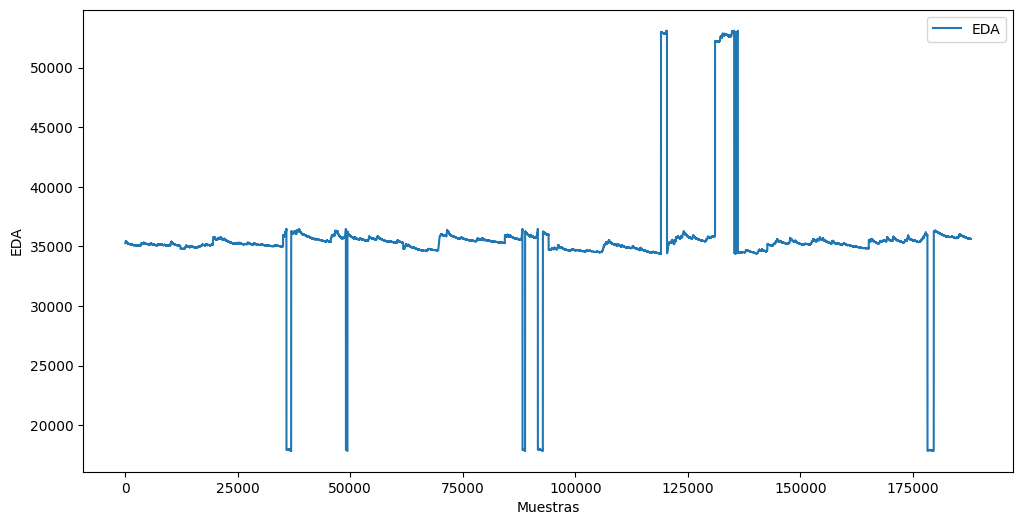

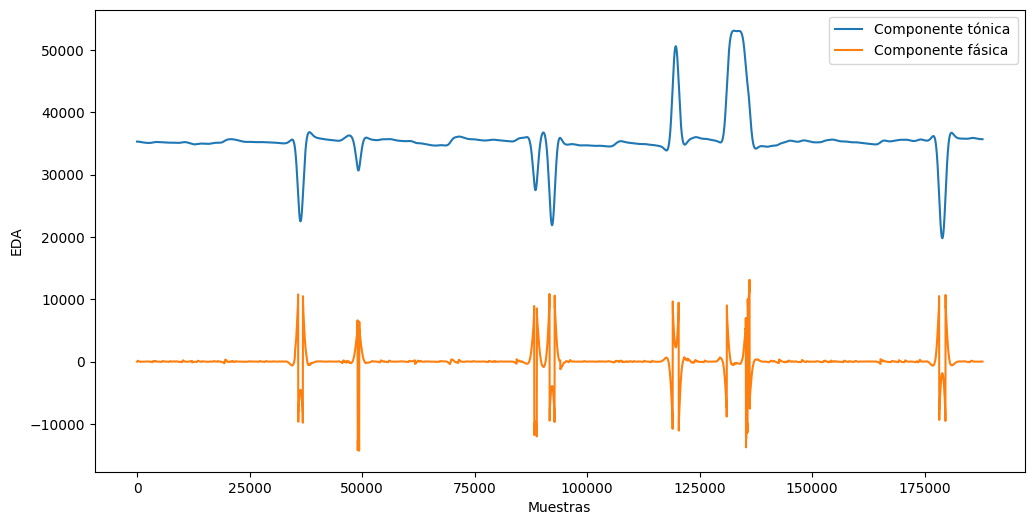

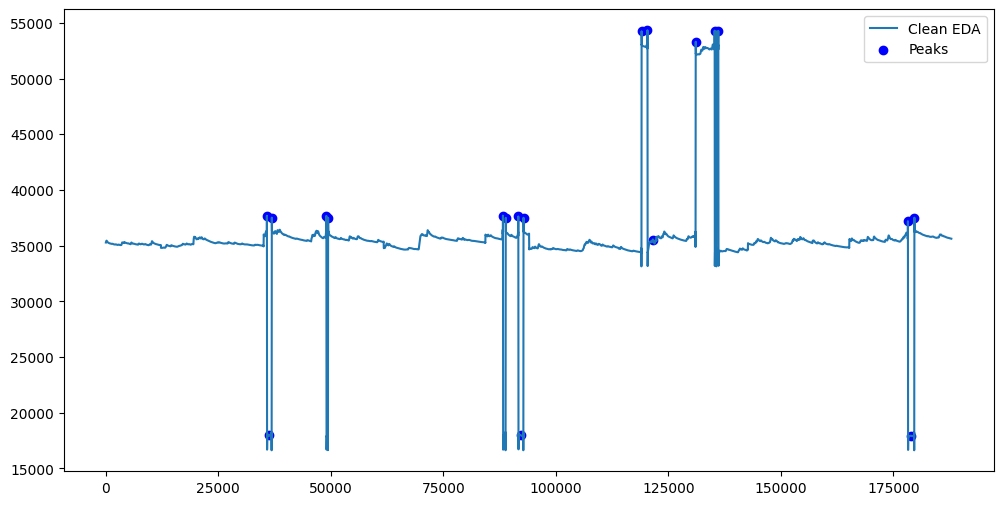

In [ ]:
#Gráfica de la señal EDA cruda y limpia
plt.figure(figsize=(12, 6))
plt.plot(signals["EDA_Raw"], label="EDA")
#plt.plot(signals["EDA_Clean"], label="Clean EDA")
#plt.title("Señal EDA Cruda y Limpia")
plt.xlabel("Muestras")
plt.ylabel("EDA")
plt.legend()
plt.show()

# Gráfica de la señal Tónica y Fásica
plt.figure(figsize=(12, 6))
plt.plot(signals["EDA_Tonic"], label="Componente tónica")
plt.plot(signals["EDA_Phasic"], label="Componente fásica ")
#plt.title("Señal Tónica y Fásica")
plt.xlabel("Muestras")
plt.ylabel("EDA")
plt.legend()
plt.show()

# Gráfica de la señal EDA con puntos de onsets y offsets marcados
plt.figure(figsize=(12, 6))
plt.plot(signals["EDA_Clean"], label="Clean EDA")
#plt.scatter(info["SCR_Onsets"], signals["EDA_Clean"].iloc[info["SCR_Onsets"]], c='r', marker='o', label="Onsets")
plt.scatter(info["SCR_Peaks"], signals["EDA_Clean"].iloc[info["SCR_Peaks"]], c='b', marker='o', label="Peaks")
plt.legend()
plt.show()





##Clasificación en los 2 niveles usando SAX

In [ ]:
#!pip install pyts


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.7 MB/s eta 0:00:00


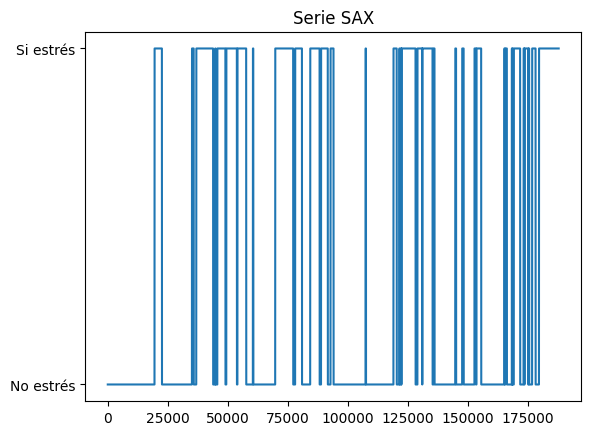

In [ ]:
from pyts.approximation import SymbolicAggregateApproximation
import matplotlib.pyplot as plt

# Suponiendo que 'normalizados' contiene la señal normalizada

# Se discretiza la señal normalizada en 2 niveles de estrés.
niveles = 2

# Se aplica SAX directamente a la señal normalizada
sax = SymbolicAggregateApproximation(n_bins=niveles, strategy='uniform')
serie_sax = sax.fit_transform(signals["EDA_Clean"].values.reshape(1, -1))

# Visualizar la serie SAX
fig, ax = plt.subplots()
ax.plot(serie_sax[0])
ax.set_yticks([0, 1])
ax.set_yticklabels(['No estrés', 'Si estrés'])  # Cambia las etiquetas según tus necesidades
ax.set_title('Serie SAX')
plt.show()


##Creación del dataset

In [ ]:
import pandas as pd
from pyts.approximation import SymbolicAggregateApproximation

# Suponiendo que tienes una serie llamada 'signals' que contiene los datos de EDA clean

# Discretizar la señal EDA usando SAX
niveles = 2
sax = SymbolicAggregateApproximation(n_bins=niveles, strategy='uniform')
serie_sax = sax.fit_transform(signals["EDA_Clean"].values.reshape(1, -1))[0]

# Asignar la categoría de estrés (0 o 1)
categorias_estres = [0 if valor == 'a' else 1 for valor in serie_sax]

# Crear un DataFrame con los datos EDA clean y la columna de estrés
data = pd.DataFrame({'EDA_Clean': signals["EDA_Clean"], 'Estres': categorias_estres})

grupo_size = 7680
data['Grupo'] = data.index // grupo_size

# Calcular si hay más 0 o 1 en cada grupo
data= data.groupby('Grupo')['Estres'].apply(lambda x: (x == 0).sum() > (x == 1).sum()).astype(int).reset_index(name='Estres')





In [ ]:
#seleccionamos las columnas que nos interesan
eda_tonic = signals['EDA_Tonic']
phasic = signals['EDA_Phasic']

#creamos una ventana de 240 muestras
ventana = 7680
#agregamos los valores de la ventana
agregacion = eda_tonic.groupby(eda_tonic.index // ventana).agg(['max', 'mean'])
#añadimos agregacion del rise time y de peaks
#max of phasic (SCR)peaks and std of phasic (SCR) RISE TIME
agregacion['max_peaks'] = signals['SCR_Peaks'].groupby(signals['SCR_Peaks'].index // ventana).max()
agregacion['std_riseTime'] = signals['SCR_RiseTime'].groupby(signals['SCR_RiseTime'].index // ventana).std()
#number of peaks in phasic
agregacion['n_peaks'] = signals['SCR_Peaks'].groupby(signals['SCR_Peaks'].index // ventana).sum()
agregacion['estres']=data['Estres']
agregacion['ID']=15
print(agregacion)


#lo almacenamos en un csv
# Guardar el DataFrame en un archivo CSV
#agregacion.to_csv('EDA_AMIGOS.csv', index=False,mode='a', header=False)

             max          mean  max_peaks  std_riseTime  n_peaks  estres  ID
0   18221.268848  18158.106702          0      0.000000        0       1  15
1   18452.960966  18228.131823          0      0.000000        0       1  15
2   18575.352247  18458.747063          0      0.000000        0       1  15
3   18496.504268  18423.112418          0      0.000000        0       1  15
4   18474.264722  18431.366634          0      0.000000        0       1  15
5   18391.461586  18310.365066          0      0.000000        0       1  15
6   18222.088245  18133.653728          0      0.000000        0       1  15
7   18331.951149  18267.812307          0      0.000000        0       1  15
8   18247.764995  18122.610500          0      0.000000        0       1  15
9   18617.454145  18514.742284          0      0.000000        0       1  15
10  18788.179732  18700.259086          0      0.000000        0       1  15
11  18574.751438  18479.023482          0      0.000000        0       1  15

In [ ]:
import pandas as pd

# Leer el archivo CSV y cargarlo en un DataFrame
data = pd.read_csv('/content/drive/MyDrive/TFG/EDA_AMIGOS.csv')
print(data.head())

print(data.tail())




            max          mean  max_peaks  std_riseTime  n_peaks  estres  ID
0  35301.260142  35172.677316          0      0.000000        0       1   1
1  35221.285546  35046.480930          0      0.000000        0       1   1
2  35687.474789  35318.597280          0      0.000000        0       1   1
3  35388.944971  35221.455176          0      0.000000        0       1   1
4  36809.889884  33015.012106          1      0.040077        3       1   1
              max          mean  max_peaks  std_riseTime  n_peaks  estres  ID
370  18596.474838  18359.302244          0           0.0        0       1  15
371  18425.928736  18343.432090          0           0.0        0       1  15
372  18483.058103  18377.548636          0           0.0        0       1  15
373  18486.815116  18429.692622          0           0.0        0       1  15
374  18457.152290  18418.483953          0           0.0        0       1  15


##EXPERIMENTOS

##SVM, LOGO

Accuracy: 0.72 Sujeto de test: [1]
Accuracy: 0.08 Sujeto de test: [2]
Accuracy: 0.00 Sujeto de test: [3]
Accuracy: 0.40 Sujeto de test: [4]
Accuracy: 0.88 Sujeto de test: [5]
Accuracy: 0.04 Sujeto de test: [6]
Accuracy: 0.12 Sujeto de test: [7]
Accuracy: 0.72 Sujeto de test: [8]
Accuracy: 0.68 Sujeto de test: [9]
Accuracy: 0.16 Sujeto de test: [10]
Accuracy: 0.00 Sujeto de test: [11]
Accuracy: 0.64 Sujeto de test: [12]
Accuracy: 0.96 Sujeto de test: [13]
Accuracy: 0.92 Sujeto de test: [14]
Accuracy: 1.00 Sujeto de test: [15]
Accuracy(media): 0.49
Accuracy (mediana): 0.64


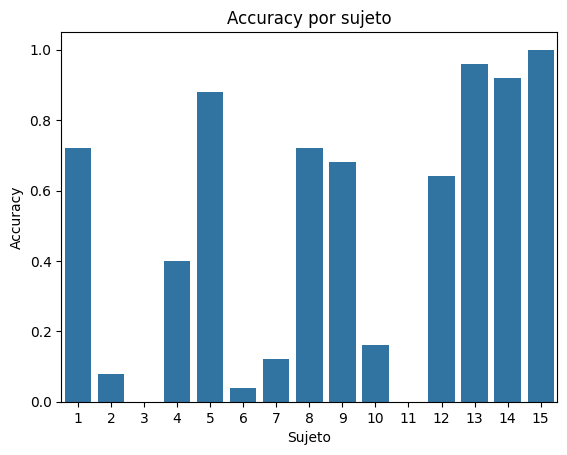

In [ ]:
#CREACION DEL MODELO DE SVM
#SEPARACION DE LOS DATOS USANDO LEAVE ONE GROUP OUT
# ==============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

#ABRIR EL CSV
# ==============================================================================
fichero_csv= 'EDA_AMIGOS.csv'
datos =pd.read_csv(fichero_csv)

#SEPARAMOS LOS DATOS EN TRAIN Y TEST
# ==============================================================================

X = datos.iloc[:,0:-2]
y = datos.iloc[:,-2]
#SEPARACION EN TRAIN Y TEST
# ==============================================================================
grupos = datos['ID']
logo = LeaveOneGroupOut()
accuracy = []
modelo = SVC(kernel='linear')
for train_index, test_index in logo.split(X, y, grupos):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f} Sujeto de test: {grupos.iloc[test_index].unique()}')
accuracy = np.array(accuracy)
print(f'Accuracy(media): {accuracy.mean():.2f}')
print(f'Accuracy (mediana): {np.median(accuracy):.2f}')

#MOSTRAR UN GRAFICO DE BARRAS CON EL ACCURACY DE CADA SUJETO
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(x=grupos.unique(), y=accuracy, ax=ax)
ax.set_title('Accuracy por sujeto')
ax.set_xlabel('Sujeto')
ax.set_ylabel('Accuracy')
plt.show()


##SVM  LOSO+CROSS VALIDATION

In [ ]:
#CREACION DEL MODELO DE SVM TIPO EXPERIMENTO 5
#CON NORMALIZACION
#SEPARACION DE LOS DATOS USANDO LEAVE ONE GROUP OUT Y CROSS VALIDATION
# ==============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

#ABRIR EL CSV
# ==============================================================================

fichero_csv= '/content/drive/MyDrive/TFG/EDA_AMIGOS.csv'
datos =pd.read_csv(fichero_csv)

#SEPARAMOS LOS DATOS EN TRAIN Y TEST
# ==============================================================================
X = datos.iloc[:,0:-2]
y = datos.iloc[:,-2]

#DEFINIMOS CROSS VALIDATION
# ==============================================================================
cv= LeaveOneOut()

#CREAMOS EL MODELO
# ==============================================================================
modelo = SVC(kernel='linear', coef0=1)

#Entrenamos el modelo
modelo.fit(X, y)

#UTILIZAMOS LOOCV PARA EVALUAR EL MODELO
# ==============================================================================
scores = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)

#MOSTRAMOS LOS RESULTADOS
# ==============================================================================
print(f'Accuracy(media): {scores.mean():.2f}')


Accuracy(media): 0.57


#BOSQUES ALEATORIOS, LOSO



In [ ]:

#SEPARACION DE LOS DATOS USANDO LEAVE ONE GROUP OUT
# ==============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

#ABRIR EL CSV
# ==============================================================================
fichero_csv= 'EDA_AMIGOS.csv'
datos =pd.read_csv(fichero_csv)

#SEPARAMOS LOS DATOS EN TRAIN Y TEST
# ==============================================================================
X = datos.iloc[:,0:-2]
y = datos.iloc[:,-2]

#SEPARACION EN TRAIN Y TEST
# ==============================================================================
grupos = datos['ID']
logo = LeaveOneGroupOut()
accuracy = []
modelo = RandomForestClassifier(n_estimators=700, random_state=0)


for train_index, test_index in logo.split(X, y, grupos):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f} Sujeto de test: {grupos.iloc[test_index].unique()}')
accuracy = np.array(accuracy)
print(f'Accuracy(media): {accuracy.mean():.2f}')
print(f'Accuracy (mediana): {np.median(accuracy):.2f}')


Accuracy: 0.60 Sujeto de test: [1]
Accuracy: 1.00 Sujeto de test: [2]
Accuracy: 0.72 Sujeto de test: [3]
Accuracy: 1.00 Sujeto de test: [4]
Accuracy: 0.88 Sujeto de test: [5]
Accuracy: 1.00 Sujeto de test: [6]
Accuracy: 0.92 Sujeto de test: [7]
Accuracy: 0.96 Sujeto de test: [8]
Accuracy: 1.00 Sujeto de test: [9]
Accuracy: 0.72 Sujeto de test: [10]
Accuracy: 0.80 Sujeto de test: [11]
Accuracy: 0.92 Sujeto de test: [12]
Accuracy: 0.84 Sujeto de test: [13]
Accuracy: 0.88 Sujeto de test: [14]
Accuracy: 1.00 Sujeto de test: [15]
Accuracy(media): 0.88
Accuracy (mediana): 0.92


##BOSQUES ALEATORIOS LOSO + CROSS VALIDATION

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

#ABRIR EL CSV
# ==============================================================================
fichero_csv= 'EDA_AMIGOS.csv'
datos =pd.read_csv(fichero_csv)

#SEPARAMOS LOS DATOS EN TRAIN Y TEST
# ==============================================================================
X = datos.iloc[:,0:-2]
y = datos.iloc[:,-2]

#DEFINIMOS CROSS VALIDATION
# ==============================================================================
cv= LeaveOneOut()

#CREAMOS EL MODELO
# ==============================================================================
modelo = RandomForestClassifier(n_estimators=700, random_state=0)

# Entrenar el modelo de Bosques Aleatorios
modelo.fit(X, y)

#UTILIZAMOS LOOCV PARA EVALUAR EL MODELO
# ==============================================================================
scores = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)

#MOSTRAMOS LOS RESULTADOS
# ==============================================================================
print(f'Accuracy(media): {scores.mean():.2f}')

Accuracy(media): 0.93


##DATOS NORMALIZADOS:

In [ ]:
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.1 MB/s eta 0:00:00


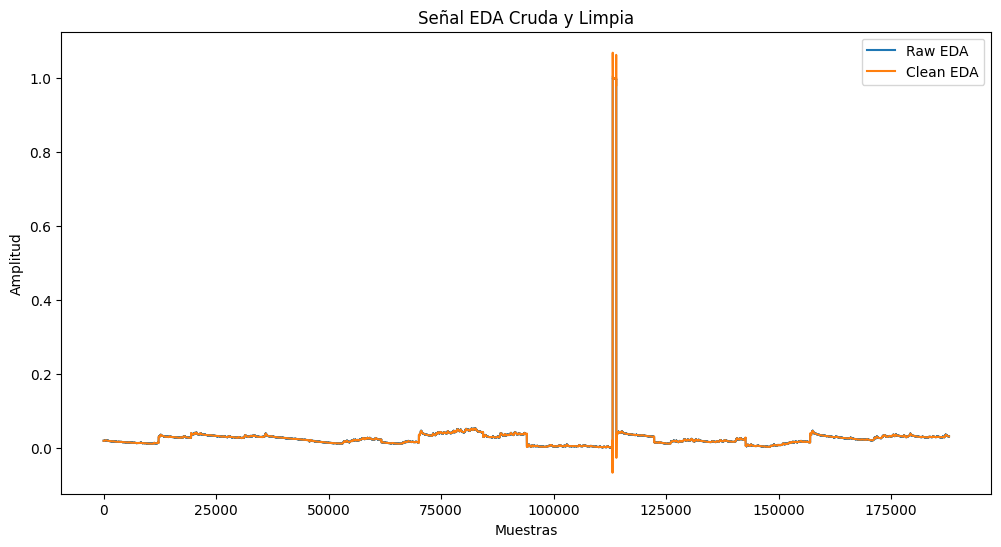

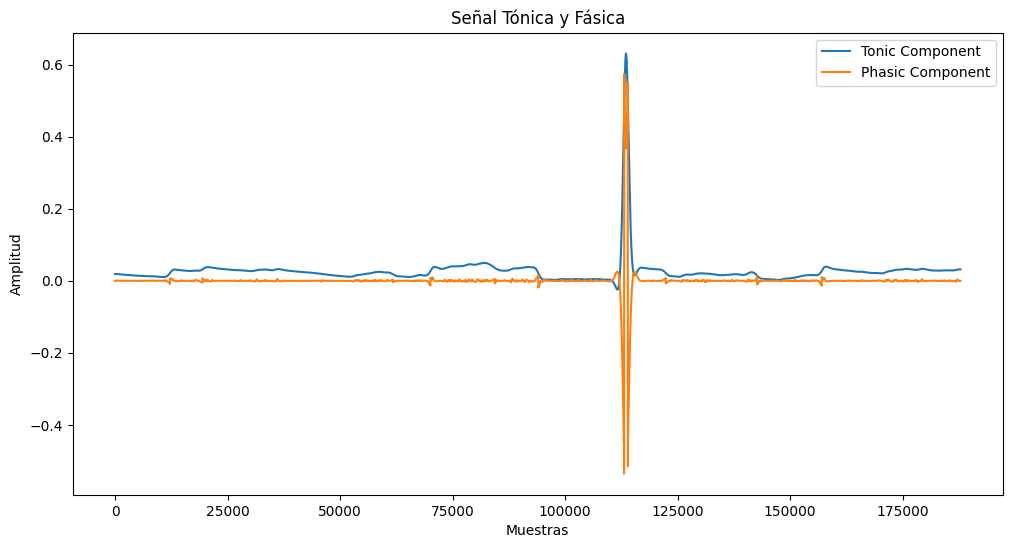

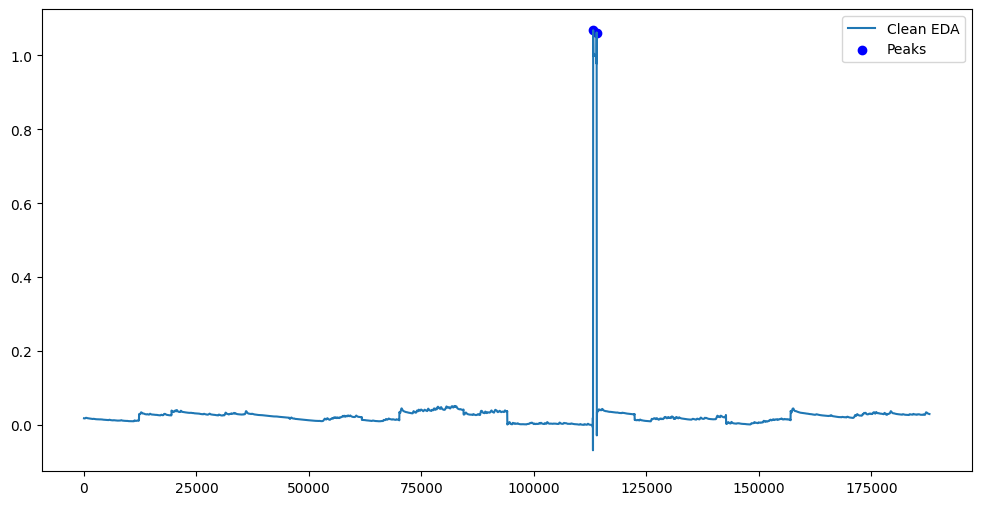

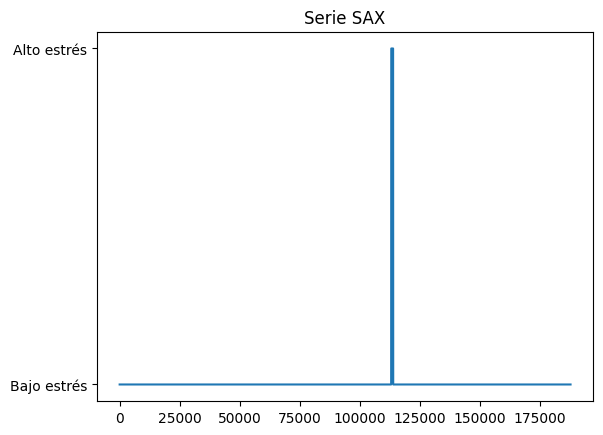

         max      mean  max_peaks  std_riseTime  n_peaks  estres  ID
0   0.018934  0.015500          0      0.000000        0       1  15
1   0.031530  0.019307          0      0.000000        0       1  15
2   0.038184  0.031844          0      0.000000        0       1  15
3   0.033897  0.029907          0      0.000000        0       1  15
4   0.032688  0.030356          0      0.000000        0       1  15
5   0.028186  0.023778          0      0.000000        0       1  15
6   0.018978  0.014171          0      0.000000        0       1  15
7   0.024951  0.021464          0      0.000000        0       1  15
8   0.020374  0.013570          0      0.000000        0       1  15
9   0.040473  0.034889          0      0.000000        0       1  15
10  0.049754  0.044974          0      0.000000        0       1  15
11  0.038151  0.032947          0      0.000000        0       1  15
12  0.037956  0.012069          0      0.000000        0       1  15
13  0.005052  0.004436          0 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mat= scipy.io.loadmat('/content/drive/MyDrive/TFG/AMIGOS/Data_Original_P15.mat')
data=mat['GSR_DATA']#me devuelve las 20 matrices de cada uno de los videos
# Asignar las variables directamente desde data
video1 = data[0][0]
video2 = data[0][1]
video3 = data[0][2]
video4 = data[0][3]
video5 = data[0][4]
video6 = data[0][5]
video7 = data[0][6]
video8 = data[0][7]
video9 = data[0][8]
video10 = data[0][9]
video11 = data[0][10]
video12 = data[0][11]
video13 = data[0][12]
video14 = data[0][13]
video15 = data[0][14]
video16 = data[0][15]
#signal = np.concatenate((video1[:, 1], video2[:, 1], video3[:,1], video4[:,1],video5[:,1],video6[:,1]))
import numpy as np


# Concatenar los datos de EDA de los videos del 1 al 16
signal = np.concatenate((video1[:, 1], video2[:, 1], video3[:, 1], video4[:, 1], video5[:, 1], video6[:, 1],
                         video7[:, 1], video8[:, 1], video9[:, 1], video10[:, 1], video11[:, 1], video12[:, 1],
                         video13[:, 1], video14[:, 1], video15[:, 1], video16[:, 1]))

import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd

# Normalizar la señal EDA
scaler = MinMaxScaler()
signal_normalized = scaler.fit_transform(signal.reshape(-1, 1)).flatten()

signals, info = nk.eda_process(signal_normalized, sampling_rate=128)

#Gráfica de la señal EDA cruda y limpia
plt.figure(figsize=(12, 6))
plt.plot(signals["EDA_Raw"], label="Raw EDA")
plt.plot(signals["EDA_Clean"], label="Clean EDA")
plt.title("Señal EDA Cruda y Limpia")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.show()

# Gráfica de la señal Tónica y Fásica
plt.figure(figsize=(12, 6))
plt.plot(signals["EDA_Tonic"], label="Tonic Component")
plt.plot(signals["EDA_Phasic"], label="Phasic Component")
plt.title("Señal Tónica y Fásica")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.show()

# Gráfica de la señal EDA con puntos de onsets y offsets marcados
plt.figure(figsize=(12, 6))
plt.plot(signals["EDA_Clean"], label="Clean EDA")
#plt.scatter(info["SCR_Onsets"], signals["EDA_Clean"].iloc[info["SCR_Onsets"]], c='r', marker='o', label="Onsets")
plt.scatter(info["SCR_Peaks"], signals["EDA_Clean"].iloc[info["SCR_Peaks"]], c='b', marker='o', label="Peaks")
plt.legend()
plt.show()

from pyts.approximation import SymbolicAggregateApproximation
import matplotlib.pyplot as plt

# Suponiendo que 'normalizados' contiene la señal normalizada

# Se discretiza la señal normalizada en 2 niveles de estrés.
niveles = 2

# Se aplica SAX directamente a la señal normalizada
sax = SymbolicAggregateApproximation(n_bins=niveles, strategy='uniform')
serie_sax = sax.fit_transform(signals["EDA_Clean"].values.reshape(1, -1))

# Visualizar la serie SAX
fig, ax = plt.subplots()
ax.plot(serie_sax[0])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Bajo estrés', 'Alto estrés'])  # Cambia las etiquetas según tus necesidades
ax.set_title('Serie SAX')
plt.show()


import pandas as pd
from pyts.approximation import SymbolicAggregateApproximation

# Suponiendo que tienes una serie llamada 'signals' que contiene los datos de EDA clean

# Discretizar la señal EDA usando SAX
niveles = 2
sax = SymbolicAggregateApproximation(n_bins=niveles, strategy='uniform')
serie_sax = sax.fit_transform(signals["EDA_Clean"].values.reshape(1, -1))[0]

# Asignar la categoría de estrés (0 o 1)
categorias_estres = [0 if valor == 'a' else 1 for valor in serie_sax]

# Crear un DataFrame con los datos EDA clean y la columna de estrés
data = pd.DataFrame({'EDA_Clean': signals["EDA_Clean"], 'Estres': categorias_estres})

grupo_size = 7680
data['Grupo'] = data.index // grupo_size

# Calcular si hay más 0 o 1 en cada grupo
data= data.groupby('Grupo')['Estres'].apply(lambda x: (x == 0).sum() > (x == 1).sum()).astype(int).reset_index(name='Estres')

#seleccionamos las columnas que nos interesan
eda_tonic = signals['EDA_Tonic']
phasic = signals['EDA_Phasic']

#creamos una ventana de 240 muestras
ventana = 7680
#agregamos los valores de la ventana
agregacion = eda_tonic.groupby(eda_tonic.index // ventana).agg(['max', 'mean'])
#añadimos agregacion del rise time y de peaks
#max of phasic (SCR)peaks and std of phasic (SCR) RISE TIME
agregacion['max_peaks'] = signals['SCR_Peaks'].groupby(signals['SCR_Peaks'].index // ventana).max()
agregacion['std_riseTime'] = signals['SCR_RiseTime'].groupby(signals['SCR_RiseTime'].index // ventana).std()
#number of peaks in phasic
agregacion['n_peaks'] = signals['SCR_Peaks'].groupby(signals['SCR_Peaks'].index // ventana).sum()
agregacion['estres']=data['Estres']
agregacion['ID']=15
print(agregacion)


#lo almacenamos en un csv
# Guardar el DataFrame en un archivo CSV  #mode='a', header=False
agregacion.to_csv('EDA_AMIGOS_NORMALIZADOS.csv', index=False, mode='a', header=False)


import pandas as pd

# Leer el archivo CSV y cargarlo en un DataFrame
data = pd.read_csv('EDA_AMIGOS_NORMALIZADOS.csv')
print(data.head())
print(data.tail())

In [ ]:
import pandas as pd

fichero_csv= '/content/drive/MyDrive/TFG/EDA_AMIGOS_NORMALIZADOS.csv'
data =pd.read_csv(fichero_csv)

# Filtrar las filas donde la columna 'estres' es igual a 1
estres_1 = data[data['estres'] == 1]

# Filtrar las filas donde la columna 'estres' es igual a 0
estres_0 = data[data['estres'] == 0]

# Contar el número de filas para cada clase
num_estres_1 = len(estres_1)
num_estres_0 = len(estres_0)

# Calcular la proporción de cada clase
prop_estres_1 = num_estres_1 / len(data)
prop_estres_0 = num_estres_0 / len(data)

print("Número de filas con estres = 1:", num_estres_1)
print("Número de filas con estres = 0:", num_estres_0)
print("Proporción de filas con estres = 1:", prop_estres_1)
print("Proporción de filas con estres = 0:", prop_estres_0)


Número de filas con estres = 1: 220
Número de filas con estres = 0: 155
Proporción de filas con estres = 1: 0.5866666666666667
Proporción de filas con estres = 0: 0.41333333333333333


##EXPERIMENTOS

##SVM + LOSO

Accuracy: 0.60 Sujeto de test: [1]
Accuracy: 1.00 Sujeto de test: [2]
Accuracy: 1.00 Sujeto de test: [3]
Accuracy: 1.00 Sujeto de test: [4]
Accuracy: 0.72 Sujeto de test: [5]
Accuracy: 0.96 Sujeto de test: [6]
Accuracy: 1.00 Sujeto de test: [7]
Accuracy: 0.64 Sujeto de test: [8]
Accuracy: 0.96 Sujeto de test: [9]
Accuracy: 0.92 Sujeto de test: [10]
Accuracy: 1.00 Sujeto de test: [11]
Accuracy: 0.88 Sujeto de test: [12]
Accuracy: 1.00 Sujeto de test: [13]
Accuracy: 0.96 Sujeto de test: [14]
Accuracy: 1.00 Sujeto de test: [15]
Accuracy(media): 0.91
Accuracy (mediana): 0.96


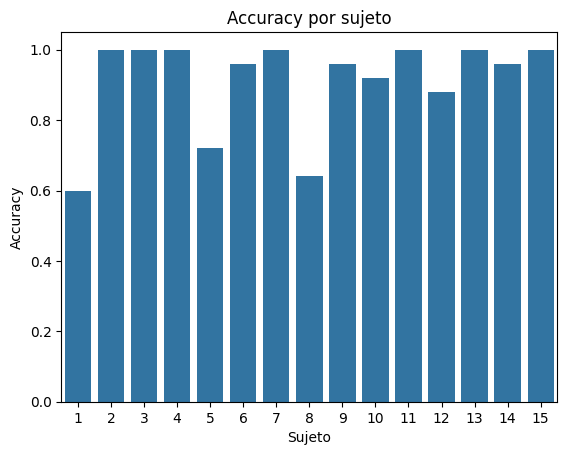

In [ ]:
#CREACION DEL MODELO DE SVM
#SEPARACION DE LOS DATOS USANDO LEAVE ONE GROUP OUT
# ==============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

#ABRIR EL CSV
# ==============================================================================
fichero_csv= '/content/drive/MyDrive/TFG/EDA_AMIGOS_NORMALIZADOS.csv'
datos =pd.read_csv(fichero_csv)

#SEPARAMOS LOS DATOS EN TRAIN Y TEST
# ==============================================================================

X = datos.iloc[:,0:-2]
y = datos.iloc[:,-2]
#SEPARACION EN TRAIN Y TEST
# ==============================================================================
grupos = datos['ID']
logo = LeaveOneGroupOut()
accuracy = []
modelo = SVC(kernel='linear')
for train_index, test_index in logo.split(X, y, grupos):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f} Sujeto de test: {grupos.iloc[test_index].unique()}')
accuracy = np.array(accuracy)
print(f'Accuracy(media): {accuracy.mean():.2f}')
print(f'Accuracy (mediana): {np.median(accuracy):.2f}')

#MOSTRAR UN GRAFICO DE BARRAS CON EL ACCURACY DE CADA SUJETO
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(x=grupos.unique(), y=accuracy, ax=ax)
ax.set_title('Accuracy por sujeto')
ax.set_xlabel('Sujeto')
ax.set_ylabel('Accuracy')
plt.show()


##SVM LOSO + CROSS VALIDATION

Accuracy(media): 0.93


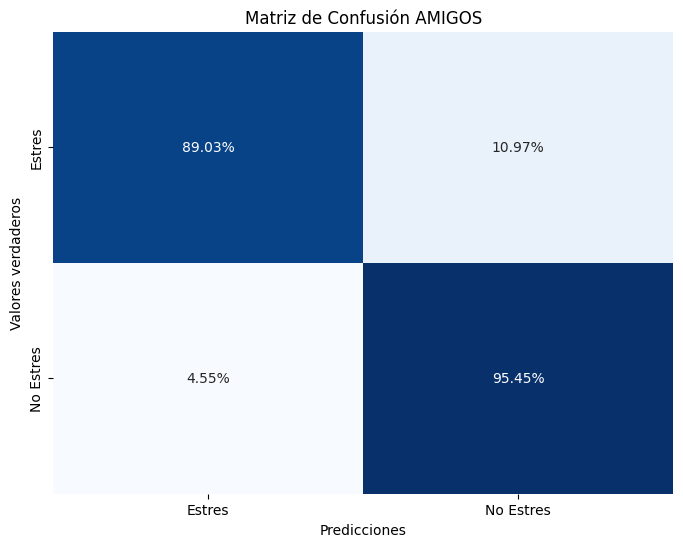

In [ ]:
#CREACION DEL MODELO DE SVM TIPO EXPERIMENTO 5
#CON NORMALIZACION
#SEPARACION DE LOS DATOS USANDO LEAVE ONE GROUP OUT Y CROSS VALIDATION
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#ABRIR EL CSV
# ==============================================================================

fichero_csv= '/content/drive/MyDrive/TFG/EDA_AMIGOS_NORMALIZADOS.csv'
datos =pd.read_csv(fichero_csv)

#SEPARAMOS LOS DATOS EN TRAIN Y TEST
# ==============================================================================
X = datos.iloc[:,0:-2]
y = datos.iloc[:,-2]

#DEFINIMOS CROSS VALIDATION
# ==============================================================================
cv= LeaveOneOut()

#CREAMOS EL MODELO
# ==============================================================================
modelo = SVC(kernel='linear', coef0=1)

#Entrenamos el modelo
modelo.fit(X, y)

#UTILIZAMOS LOOCV PARA EVALUAR EL MODELO
# ==============================================================================
scores = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)

#MOSTRAMOS LOS RESULTADOS
# ==============================================================================
print(f'Accuracy(media): {scores.mean():.2f}')

# OBTENEMOS LAS PREDICCIONES USANDO CROSS VAL PREDICT PARA LA MATRIZ DE CONFUSIÓN
# ==============================================================================
y_pred = cross_val_predict(modelo, X, y, cv=cv, n_jobs=-1)

# CALCULAR LA MATRIZ DE CONFUSIÓN
# ==============================================================================
conf_mat = confusion_matrix(y, y_pred)

# CALCULAR LOS PORCENTAJES
# ==============================================================================
conf_mat_porcentaje = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# CREAR UN HEATMAP DE LA MATRIZ DE CONFUSIÓN
# ==============================================================================
# CREAR UN HEATMAP DE LA MATRIZ DE CONFUSIÓN CON NOMBRES DE CATEGORÍAS
# ==============================================================================
categorias = ["Estres", "No Estres"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_porcentaje, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=categorias, yticklabels=categorias)
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión AMIGOS')
plt.show()

##BOSQUES ALEATORIOS LOSO

Accuracy: 0.68 Sujeto de test: [1]
Accuracy: 1.00 Sujeto de test: [2]
Accuracy: 1.00 Sujeto de test: [3]
Accuracy: 1.00 Sujeto de test: [4]
Accuracy: 0.72 Sujeto de test: [5]
Accuracy: 1.00 Sujeto de test: [6]
Accuracy: 1.00 Sujeto de test: [7]
Accuracy: 0.80 Sujeto de test: [8]
Accuracy: 1.00 Sujeto de test: [9]
Accuracy: 1.00 Sujeto de test: [10]
Accuracy: 1.00 Sujeto de test: [11]
Accuracy: 1.00 Sujeto de test: [12]
Accuracy: 1.00 Sujeto de test: [13]
Accuracy: 1.00 Sujeto de test: [14]
Accuracy: 1.00 Sujeto de test: [15]
Accuracy(media): 0.95
Accuracy (mediana): 1.00


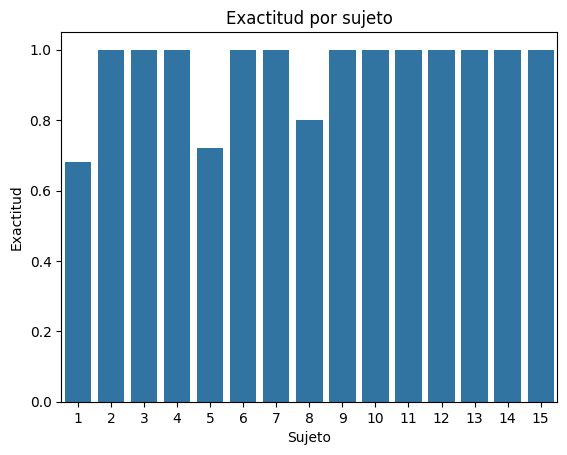

In [ ]:
#SEPARACION DE LOS DATOS USANDO LEAVE ONE GROUP OUT
# ==============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

#ABRIR EL CSV
# ==============================================================================
fichero_csv= '/content/drive/MyDrive/TFG/EDA_AMIGOS_NORMALIZADOS.csv'
datos =pd.read_csv(fichero_csv)

#SEPARAMOS LOS DATOS EN TRAIN Y TEST
# ==============================================================================
X = datos.iloc[:,0:-2]
y = datos.iloc[:,-2]

#SEPARACION EN TRAIN Y TEST
# ==============================================================================
grupos = datos['ID']
logo = LeaveOneGroupOut()
accuracy = []
modelo = RandomForestClassifier(n_estimators=700, random_state=0)


for train_index, test_index in logo.split(X, y, grupos):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f} Sujeto de test: {grupos.iloc[test_index].unique()}')
accuracy = np.array(accuracy)
print(f'Accuracy(media): {accuracy.mean():.2f}')
print(f'Accuracy (mediana): {np.median(accuracy):.2f}')
#MOSTRAR UN GRAFICO DE BARRAS CON EL ACCURACY DE CADA SUJETO
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(x=grupos.unique(), y=accuracy, ax=ax)
ax.set_title('Exactitud por sujeto')
ax.set_xlabel('Sujeto')
ax.set_ylabel('Exactitud')
plt.show()


##BOSQUES ALEATORIOS LOSO + CROSS VALIDATION

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

#ABRIR EL CSV
# ==============================================================================
fichero_csv= '/content/drive/MyDrive/TFG/EDA_AMIGOS_NORMALIZADOS.csv'
datos =pd.read_csv(fichero_csv)

#SEPARAMOS LOS DATOS EN TRAIN Y TEST
# ==============================================================================
X = datos.iloc[:,0:-2]
y = datos.iloc[:,-2]

#DEFINIMOS CROSS VALIDATION
# ==============================================================================
cv= LeaveOneOut()

#CREAMOS EL MODELO
# ==============================================================================
modelo = RandomForestClassifier(n_estimators=700, random_state=0)


#UTILIZAMOS LOOCV PARA EVALUAR EL MODELO
# ==============================================================================
scores = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)


# OBTENEMOS LAS PREDICCIONES USANDO CROSS VAL PREDICT PARA LA MATRIZ DE CONFUSIÓN
# ==============================================================================
y_pred = cross_val_predict(modelo, X, y, cv=cv, n_jobs=-1)

#MOSTRAMOS LOS RESULTADOS
# ==============================================================================
print(f'Accuracy(media): {scores.mean():.2f}')

# CALCULAR LA MATRIZ DE CONFUSIÓN
# ==============================================================================
conf_mat = confusion_matrix(y, y_pred)

# CALCULAR LOS PORCENTAJES
# ==============================================================================
conf_mat_porcentaje = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# CREAR UN HEATMAP DE LA MATRIZ DE CONFUSIÓN
# ==============================================================================
# CREAR UN HEATMAP DE LA MATRIZ DE CONFUSIÓN CON NOMBRES DE CATEGORÍAS
# ==============================================================================
categorias = ["Estres", "No Estres"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_porcentaje, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=categorias, yticklabels=categorias)
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión (Porcentaje)')
plt.show()


Accuracy(media): 0.96


NameError: name 'confusion_matrix' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Cargar los datos desde el CSV
fichero_csv = '/content/drive/MyDrive/TFG/EDA_AMIGOS_NORMALIZADOS.csv'
datos = pd.read_csv(fichero_csv)

# Separar los datos en características (X) y etiquetas (y)
X = datos.iloc[:, 0:-2].values
y = datos.iloc[:, -2].values

# Definir los grupos de sujetos para LOSO-CV
groups = datos['ID'].values  # Suponiendo que tienes una columna 'subject_id' que identifica a cada sujeto

# Inicializar el objeto de Leave-One-Group-Out CV
loso_cv = LeaveOneGroupOut()

# Inicializar la lista para almacenar los resultados de precisión
accuracy_scores = []
history_list = []

# Definir y compilar el modelo LSTM
model = Sequential()
model.add(LSTM(32, return_sequences=True,input_shape=(5,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

split_indices = list(loso_cv.split(X, y, groups))
print(split_indices)

# Iterar sobre los splits de entrenamiento y prueba generados por LOSO-CV
for i, (train_index, test_index) in enumerate(split_indices):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    history=model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
    history_list.append(history)
    acc = history.history['acc']
    # Almacenar la precisión en esta iteración
    accuracy_scores.append(acc[-1])

# Calcular y mostrar la precisión promedio
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)


[(array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 